In [23]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from datasets import load_dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [24]:
# Load dataset
ds = load_dataset("garythung/trashnet")

In [29]:
# Explore dataset
labels = [sample["label"] for sample in ds["train"]]
class_counts = Counter(labels)

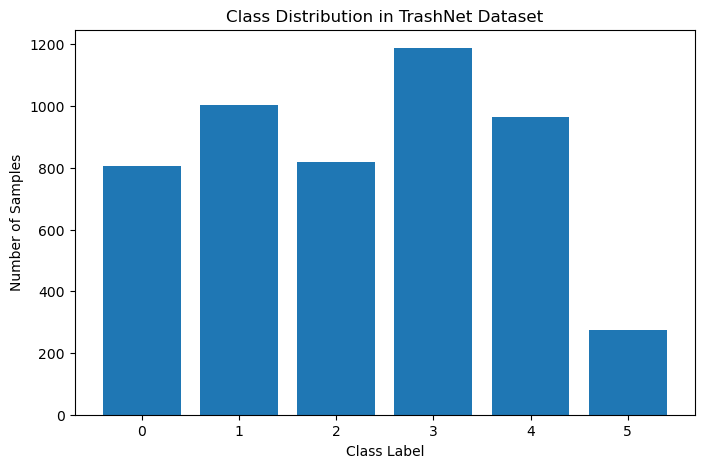

In [30]:
# Display class distribution
plt.figure(figsize=(8, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.xlabel("Class Label")
plt.ylabel("Number of Samples")
plt.title("Class Distribution in TrashNet Dataset")
plt.show()

In [32]:
# Display 3 sample images per label
unique_labels = list(class_counts.keys())
fig, axes = plt.subplots(len(unique_labels), 3, figsize=(10, 10))

for i, label in enumerate(unique_labels):
    samples = [sample for sample in ds["train"] if sample["label"] == label][:3]
    for j, sample in enumerate(samples):
        image = sample["image"]
        if not isinstance(image, Image.Image):
            image = Image.open(image)
        axes[i, j].imshow(image)
        axes[i, j].set_title(f"Class: {label}")
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()

In [15]:
# Define transformation
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Custom Dataset Class
class TrashNetDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return len(self.dataset["train"])
    
    def __getitem__(self, idx):
        image = self.dataset["train"][idx]["image"]
        
        if not isinstance(image, Image.Image):
            image = Image.open(image).convert("RGB")
        
        label = self.dataset["train"][idx]["label"]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [16]:
# Prepare dataset and dataloaders
dataset = TrashNetDataset(ds, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [17]:
# Define CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=6):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(128 * 16 * 16, 512)
        self.fc2 = nn.Linear(512, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [18]:
# Device agnostic code for Mac
if torch.backends.mps.is_available():
    device = torch.device("mps")  # Use Apple Metal Performance Shaders (MPS)
elif torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

device

device(type='mps')

In [19]:
model = SimpleCNN(num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [20]:
# Training loop
def train_model(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(dataloader):.4f}")

In [21]:
train_model(model, dataloader, criterion, optimizer)

KeyboardInterrupt: 